<a href="https://colab.research.google.com/github/csabiu/Astrostatistics/blob/main/SDSS_photoz_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supervised Regression problem

In this notebook we will use decision tree and random forests algorihtms to learn a mapping between galaxy magnitudes and colors and the spectroscopic redshift.

We will construct some learning curves to determine the best choices of the algorihtms.

We will then use feature importance to understand which of the features give us the most predictive power, and then train a very simiple algorithm with reduced feature list.


# Load some libraries

In [ ]:
pip install astroquery

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Doanload the dataset

In [ ]:
from astroquery.sdss import SDSS

# look for availabe tables and columns in
# http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx

query = " SELECT TOP 200000 objID, ra ,dec, z, zerr, class, \
        cModelMag_r as mag_r, cModelMag_g as mag_g, cModelMag_i as mag_i, \
        cModelMag_u as mag_u, cModelMag_z as mag_z \
        FROM  SpecPhotoAll  WHERE (class = 'GALAXY') \
        AND z>0.1 AND z<1. AND ra>200 AND ra<230 AND dec>10 AND dec<40"


d = SDSS.query_sql(query)

# Clean the data

In [ ]:
#you can look at the all the features available to you
# http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+PhotoObj+V
print (d.keys())

['objID', 'ra', 'dec', 'z', 'zerr', 'class', 'mag_r', 'mag_g', 'mag_i', 'mag_u', 'mag_z']


# for photo-z work
# The target/label values are spectroscopic redshifts

In [ ]:
# we will use just dereddend magnitudes
mags = ['mag_g', 'mag_r', 'mag_i','mag_z','mag_u']
d=d[d[mags[0]]==d[mags[0]]]
d=d[d[mags[1]]==d[mags[1]]]
d=d[d[mags[2]]==d[mags[2]]]
d=d[d[mags[3]]==d[mags[3]]]
d=d[d[mags[4]]==d[mags[4]]]

def f(x):
    return float(x)
f2 = np.vectorize(f)

#and color combinations created from them.
cols= []
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        cols.append(mags[i]+'-' + mags[j])

# let's load these into an input array
inputs = np.zeros((len(d), len(mags+cols)), dtype=float)
for i, key in enumerate(mags):
    inputs[:, i] = np.array(d[key])

cnt = len(mags)
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        inputs[:, cnt] = np.array(f2(d[mags[i]])) - np.array(f2(d[mags[j]]))
        cnt += 1


In [ ]:
targets = np.array(f2(d['z']))

# we will split the data into a trainind and testing sample.


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

print("Training inputs: ",x_train.shape)
print("Training outputs: ",y_train.shape)
print("Testing inputs: ",x_test.shape)
print("Testing outputs: ",y_test.shape)

Training inputs:  (121325, 19)
Training outputs:  (121325,)
Testing inputs:  (30332, 19)
Testing outputs:  (30332,)


In [ ]:
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

#see https://scikit-learn.org/stable/modules/tree.html

#help(DT)

#let's train [.fit()]  a tree on the training sample, and then make predictions on the test sample

0.006038031284484726 0.00606425879803211


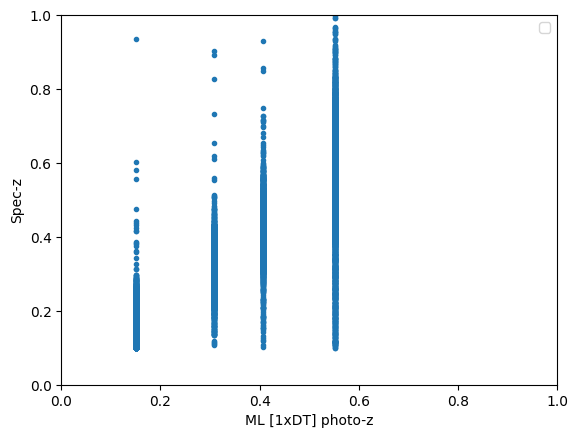

In [ ]:
clf = DT(random_state=0, max_depth=2)
clf = clf.fit(x_train, y_train)

pred_train  = clf.predict(x_train)
pred_test = clf.predict(x_test)

mse_test = mean_squared_error(y_test, pred_test)
mse_train = mean_squared_error(y_train, pred_train)
plt.plot(pred_test,y_test, '.')#, label='test MSE={:0.2f}'.format(mse_test))
plt.legend()
plt.xlabel('ML [1xDT] photo-z')
plt.ylabel('Spec-z')
plt.xlim([0,1])
plt.ylim([0,1])

print(mse_test, mse_train)


# Show graph

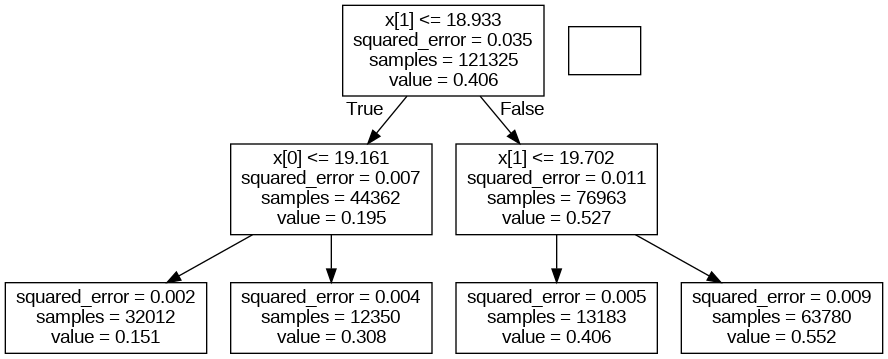

In [ ]:
#from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data=export_graphviz(clf)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

# Lets increase the number of trees -> forest

In [ ]:
#for regression [photo-z]
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

clf = RandomForestRegressor(max_depth=6,n_estimators=10)

0.004222096511832545 0.004211296354918545


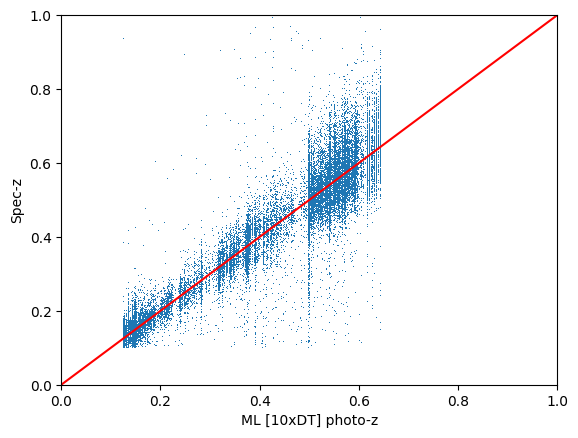

In [ ]:
clf = clf.fit(x_train, y_train)

#replace None
pred_train  = clf.predict(x_train)
pred_test = clf.predict(x_test)

mse_test = mean_squared_error(y_test, pred_test)
mse_train = mean_squared_error(y_train, pred_train)
plt.plot(pred_test,y_test, ',')#, label='test MSE={:0.2f}'.format(mse_test))
plt.xlabel('ML [10xDT] photo-z')
plt.ylabel('Spec-z')
plt.plot([0,1],[0,1],'r-')
plt.xlim([0,1])
plt.ylim([0,1])

print(mse_test, mse_train)

(0.0, 1.0)

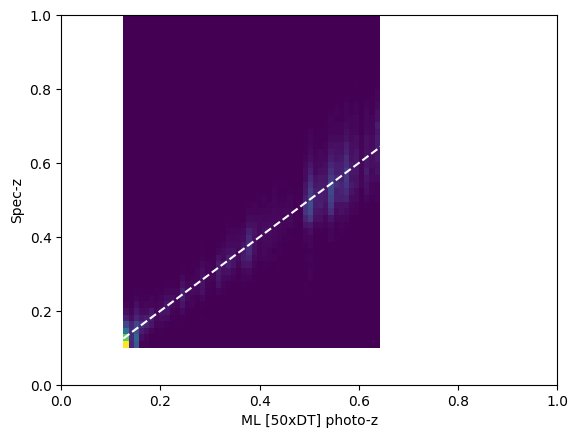

In [ ]:
plt.hist2d(pred_test,y_test, bins=50)
plt.xlabel('ML [50xDT] photo-z')
plt.ylabel('Spec-z')
plt.plot([0,1],[0,1],'w--')
plt.xlim([0,1])
plt.ylim([0,1])

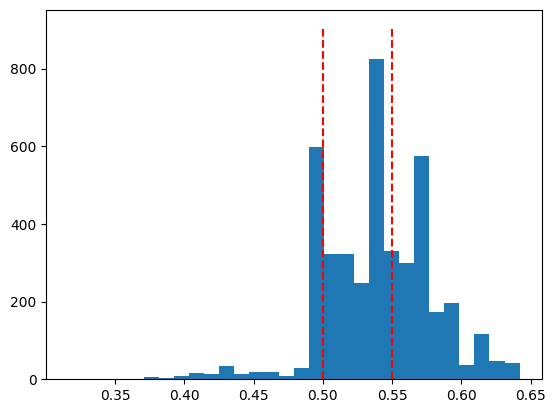

In [ ]:
specz=[0.5,0.55]
a=plt.hist(pred_test[(y_test>specz[0]) & (y_test<specz[1])],30)
plt.plot([specz[0],specz[0]],[0,1.1*np.max(a[0])],'r--')
plt.plot([specz[1],specz[1]],[0,1.1*np.max(a[0])],'r--')